Long Short-Term Memory - Speaker Independent

In [1]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

In [ ]:
# clone dataset from github
!git clone https://github.com/miftanurfarid/speech_emotion_recognition/

Cloning into 'speech_emotion_recognition'...
remote: Enumerating objects: 6970, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 6970 (delta 66), reused 101 (delta 59), pack-reused 6861
Receiving objects: 100% (6970/6970), 745.22 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (386/386), done.
Checking out files: 100% (5306/5306), done.


In [ ]:
cd speech_emotion_recognition

/content/speech_emotion_recognition/speech_emotion_recognition


In [ ]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [ ]:
# load feature data
data_path = 'data/speech/' # choose song or speech
x_train = np.load(data_path + 'x_train.npy')
x_test  = np.load(data_path + 'x_test.npy')
y_train = np.load(data_path + 'y_train.npy')
y_test  = np.load(data_path + 'y_test.npy')

# reshape x untuk lstm
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# if labels are not in integer, convert it, otherwise comment it
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
# function to define model
def model_lstm():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [ ]:
# create the model
model = model_lstm()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 1, 386)           1544      
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 1, 256)            658432    
                                                                 
 lstm_4 (LSTM)               (None, 1, 256)            525312    
                                                                 
 lstm_5 (LSTM)               (None, 1, 256)            525312    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
# plot model
tf.keras.utils.plot_model(model,'lstm_model_si_speech.pdf',show_shapes=True)

In [ ]:
# train the model
hist = model.fit(x_train, 
                 y_train, 
                 epochs=100, 
                 shuffle=True, # mengacak data
                #  callbacks=earlystop, # akan berhenti saat konvergen meskipun belum sampai maksimal iterasi
                 validation_split=0.1, # 1% utk validasi
                 batch_size=16) # setiap 1 kali training ada 16 sampel

Epoch 1/100
68/68 [==============================] - 9s 51ms/step - loss: 1.8909 - accuracy: 0.2574 - val_loss: 2.0265 - val_accuracy: 0.1917
Epoch 2/100
68/68 [==============================] - 2s 28ms/step - loss: 1.5567 - accuracy: 0.4037 - val_loss: 1.9416 - val_accuracy: 0.2917
Epoch 3/100
68/68 [==============================] - 2s 28ms/step - loss: 1.3031 - accuracy: 0.5083 - val_loss: 1.5942 - val_accuracy: 0.4500
Epoch 4/100
68/68 [==============================] - 2s 28ms/step - loss: 1.0855 - accuracy: 0.6028 - val_loss: 1.5204 - val_accuracy: 0.4750
Epoch 5/100
68/68 [==============================] - 2s 29ms/step - loss: 0.9533 - accuracy: 0.6593 - val_loss: 1.6082 - val_accuracy: 0.5167
Epoch 6/100
68/68 [==============================] - 2s 29ms/step - loss: 0.8057 - accuracy: 0.7093 - val_loss: 1.5794 - val_accuracy: 0.4917
Epoch 7/100
68/68 [==============================] - 2s 28ms/step - loss: 0.6562 - accuracy: 0.7620 - val_loss: 1.6411 - val_accuracy: 0.4917
Epoch 

In [ ]:
evaluate = model.evaluate(x_test, y_test, batch_size=16)

print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

15/15 [==============================] - 2s 8ms/step - loss: 3.2443 - accuracy: 0.4167
Loss=3.244300, Accuracy=0.416667


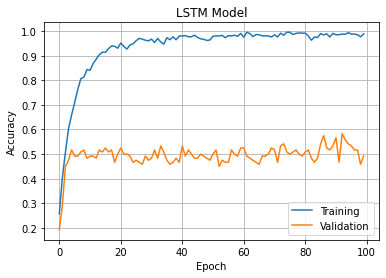

In [ ]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model')
plt.savefig('lstm_accuracy_si_speech.svg')

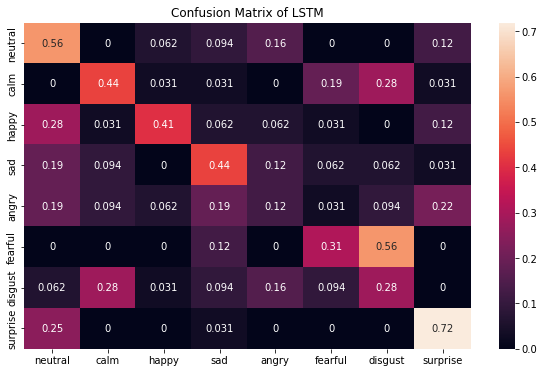

In [ ]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of LSTM')
sns.heatmap(cm_df, annot=True)
plt.savefig('lstm_cm_si_speech.svg')

In [ ]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.41015625
